In [45]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
import zipfile

!rm ./known -rf
fn = "/gdrive/My Drive/known.zip"
with zipfile.ZipFile(fn, 'r') as ff:
  ff.extractall('./')

In [96]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

print(tf.__version__) # 1.14.0
tf.test.is_gpu_available()

1.14.0


True

92 92 (512, 512, 4) (512, 512, 4)


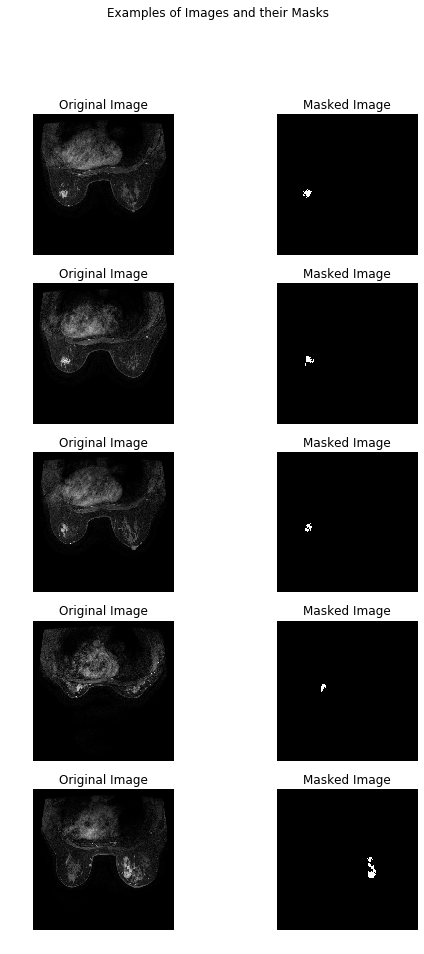

In [97]:
xx_train = tf.gfile.Glob('./known/dicom_png/*/*.png')
yy_train = [ii.replace('dicom_png', 'masks') for ii in xx_train]
print(len(xx_train), len(yy_train), plt.imread(xx_train[0]).shape, plt.imread(yy_train[0]).shape)
# 92 92 (512, 512, 4) (512, 512)

display_num = 5
r_choices = np.random.choice(len(xx_train), display_num)

fig = plt.figure(figsize=(8, 15))
for ii, cc in enumerate(r_choices):
    plt.subplot(display_num, 2, ii * 2 + 1)
    plt.imshow(plt.imread(xx_train[cc]))
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(display_num, 2, ii * 2 + 2)
    plt.imshow(plt.imread(yy_train[cc]), cmap="gray")
    plt.title("Masked Image")
    plt.axis('off')

plt.suptitle("Examples of Images and their Masks")
plt.show()

In [98]:
from sklearn.model_selection import train_test_split

xx_train = np.array(xx_train)
yy_train = np.array(yy_train)
x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
            train_test_split(xx_train, yy_train, test_size=0.2, random_state=42)

num_train_examples = x_train_filenames.shape[0]
num_val_examples = x_val_filenames.shape[0]

print("training examples: {}, validation examples: {}".format(num_train_examples, num_val_examples))
# training examples: 4070, validation examples: 1018
x_train_filenames[:3], y_train_filenames[:3]

training examples: 73, validation examples: 19


(array(['./known/dicom_png/DCE-7/IM424.png',
        './known/dicom_png/DCE-11/IM421.png',
        './known/dicom_png/DCE-7/IM417.png'], dtype='<U34'),
 array(['./known/masks/DCE-7/IM424.png', './known/masks/DCE-11/IM421.png',
        './known/masks/DCE-7/IM417.png'], dtype='<U30'))

In [0]:
from skimage.filters.rank import enhance_contrast
from skimage.color import gray2rgb, rgb2gray
from skimage.morphology.selem import disk
from skimage.io import imread
img_shape = (512, 512, 3)

# Processing each pathname
def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair  
    img_str = tf.read_file(fname)
    img = tf.image.decode_jpeg(img_str, channels=3)
    # img = tf.image.per_image_standardization(img)

    label_img_str = tf.read_file(label_path)
    # These are gif images so they return as (num_frames, h, w, c)
    label_img = tf.image.decode_gif(label_img_str)[0]
    # The label image should only have values of 1 or 0, indicating pixel wise
    # object (car) or not (background). We take the first channel only.
    label_img = label_img[:, :, 0]
    label_img = tf.expand_dims(label_img, axis=-1)
    return img, label_img

# Shifting the image
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift"""
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random_uniform([], -width_shift_range * img_shape[1], width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random_uniform([], -height_shift_range * img_shape[0], height_shift_range * img_shape[0])
        # Translate both
        output_img = tf.contrib.image.translate(output_img, [width_shift_range, height_shift_range])
        label_img = tf.contrib.image.translate(label_img, [width_shift_range, height_shift_range])
    return output_img, label_img

# Flipping the image randomly
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random_uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                      lambda: (tf.image.flip_left_right(tr_img), tf.image.flip_left_right(label_img)),
                      lambda: (tr_img, label_img))
    return tr_img, label_img

# Assembling our transformations into our augment function
def _augment(img, label_img,
             resize=None,  # Resize the image to some size e.g. [256, 256]
             scale=1,  # Scale image e.g. 1 / 255.
             hue_delta=0,  # Adjust the hue of an RGB image by random factor
             horizontal_flip=False,  # Random left right flip,
             width_shift_range=0,  # Randomly translate the image horizontally
             height_shift_range=0):  # Randomly translate the image vertically
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize_images(label_img, resize)
        img = tf.image.resize_images(img, resize)

    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)

    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.to_float(label_img) * scale
    img = tf.to_float(img) * scale

    return img, label_img

In [0]:
import functools
batch_size = 3

def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5,
                         batch_size=batch_size,
                         shuffle=True):           
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset, taking
    # advantage of multithreading
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)
    if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        assert batch_size == 1, "Batching images must be of the same size"

    dataset = dataset.map(preproc_fn, num_parallel_calls=threads)

    if shuffle:
      dataset = dataset.shuffle(num_x)

    # It's necessary to repeat our data for all epochs
    dataset = dataset.repeat().batch(batch_size)
    return dataset

# Set up train and validation datasets
# Note that we apply image augmentation to our training dataset but not our validation dataset.
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255,
    'hue_delta': 0,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

train_ds = get_baseline_dataset(x_train_filenames, y_train_filenames, preproc_fn=tr_preprocessing_fn, batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames, y_val_filenames, preproc_fn=val_preprocessing_fn, batch_size=batch_size)

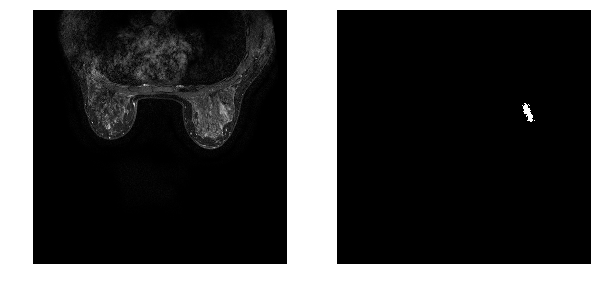

In [108]:
# Let's examine some of these augmented images
# Let's see if our image augmentor data pipeline is producing expected results
temp_ds = get_baseline_dataset(xx_train[0:100], yy_train[0:100], preproc_fn=tr_preprocessing_fn, batch_size=1, shuffle=True)
next_element = temp_ds.make_one_shot_iterator().get_next()
with tf.Session() as sess:
    batch_of_imgs, label = sess.run(next_element)

    # Running next element in our graph will produce a batch of images
    fig = plt.figure(figsize=(10, 5))
    img = batch_of_imgs[0]

    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(label[0, :, :, 0], cmap="gray")
    plt.axis('off')
    plt.show()

In [0]:
from tensorflow.python.keras import layers

def conv_block(input_tensor, num_filters):
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
    encoder = layers.BatchNormalization()(encoder)
    encoder = layers.Activation('relu')(encoder)
    return encoder

def encoder_block(input_tensor, num_filters):
    encoder = conv_block(input_tensor, num_filters)
    encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)

    return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
    decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
    decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
    decoder = layers.BatchNormalization()(decoder)
    decoder = layers.Activation('relu')(decoder)
    return decoder

inputs = layers.Input(shape=img_shape) # 256
encoder0_pool, encoder0 = encoder_block(inputs, 32) # 128
encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64) # 64
encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128) # 32
encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256) # 16
encoder4_pool, encoder4 = encoder_block(encoder3_pool, 512) # 8
center = conv_block(encoder4_pool, 1024) # center
decoder4 = decoder_block(center, encoder4, 512) # 16
decoder3 = decoder_block(decoder4, encoder3, 256) # 32
decoder2 = decoder_block(decoder3, encoder2, 128) # 64
decoder1 = decoder_block(decoder2, encoder1, 64) # 128
decoder0 = decoder_block(decoder1, encoder0, 32) # 256
outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

# Define your model
model = tf.keras.models.Model(inputs=[inputs], outputs=[outputs])

In [0]:
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss

In [111]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 512, 512, 32) 896         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, 512, 512, 32) 128         conv2d_46[0][0]                  
__________________________________________________________________________________________________
activation_54 (Activation)      (None, 512, 512, 32) 0           batch_normalization_54[0][0]     
____________________________________________________________________________________________

In [116]:
epochs = 50

SAVE_PATH = './training_checkpoints'
if not tf.gfile.Exists(SAVE_PATH): tf.gfile.MakeDirs(SAVE_PATH)
save_model_path = os.path.join(SAVE_PATH, 'weights.hdf5')
checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path, monitor='val_dice_loss', save_best_only=True, verbose=1)
history = model.fit(train_ds,
                   steps_per_epoch=int(np.ceil(num_train_examples / float(batch_size))),
                   epochs=epochs,
                   validation_data=val_ds,
                   validation_steps=int(np.ceil(num_val_examples / float(batch_size))),
                   callbacks=[checkpoints])

Epoch 1/50
24/25 [===========================>..] - ETA: 0s - loss: 0.1843 - dice_loss: 0.1800
Epoch 00001: val_dice_loss improved from inf to 0.19797, saving model to ./training_checkpoints/weights.hdf5
25/25 [==============================] - 95s 4s/step - loss: 0.1841 - dice_loss: 0.1797 - val_loss: 0.2045 - val_dice_loss: 0.1980
Epoch 2/50
24/25 [===========================>..] - ETA: 0s - loss: 0.1933 - dice_loss: 0.1890
Epoch 00002: val_dice_loss improved from 0.19797 to 0.17299, saving model to ./training_checkpoints/weights.hdf5
25/25 [==============================] - 14s 565ms/step - loss: 0.1903 - dice_loss: 0.1860 - val_loss: 0.1770 - val_dice_loss: 0.1730
Epoch 3/50
24/25 [===========================>..] - ETA: 0s - loss: 0.1793 - dice_loss: 0.1751
Epoch 00003: val_dice_loss did not improve from 0.17299
25/25 [==============================] - 13s 512ms/step - loss: 0.1783 - dice_loss: 0.1742 - val_loss: 0.2296 - val_dice_loss: 0.2244
Epoch 4/50
24/25 [====================

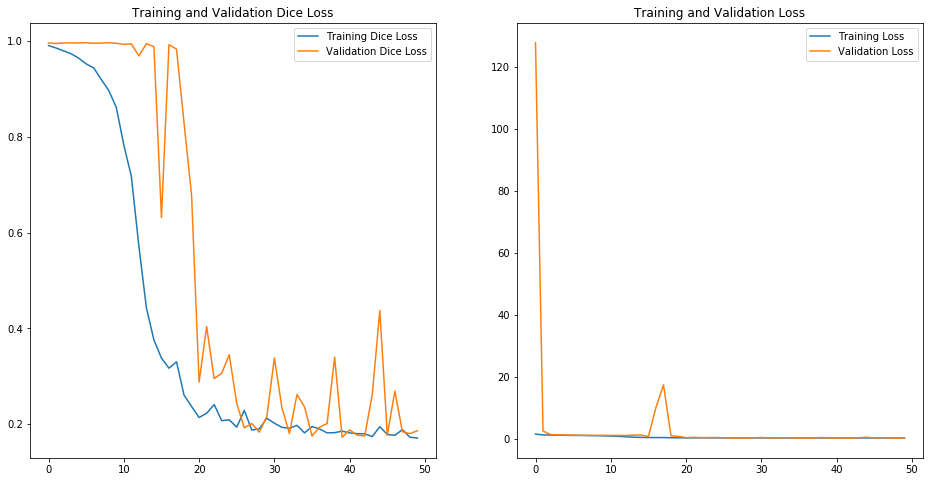

In [113]:
dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [0]:
model = tf.keras.models.load_model(save_model_path, custom_objects={'bce_dice_loss': bce_dice_loss, 'dice_loss': dice_loss})

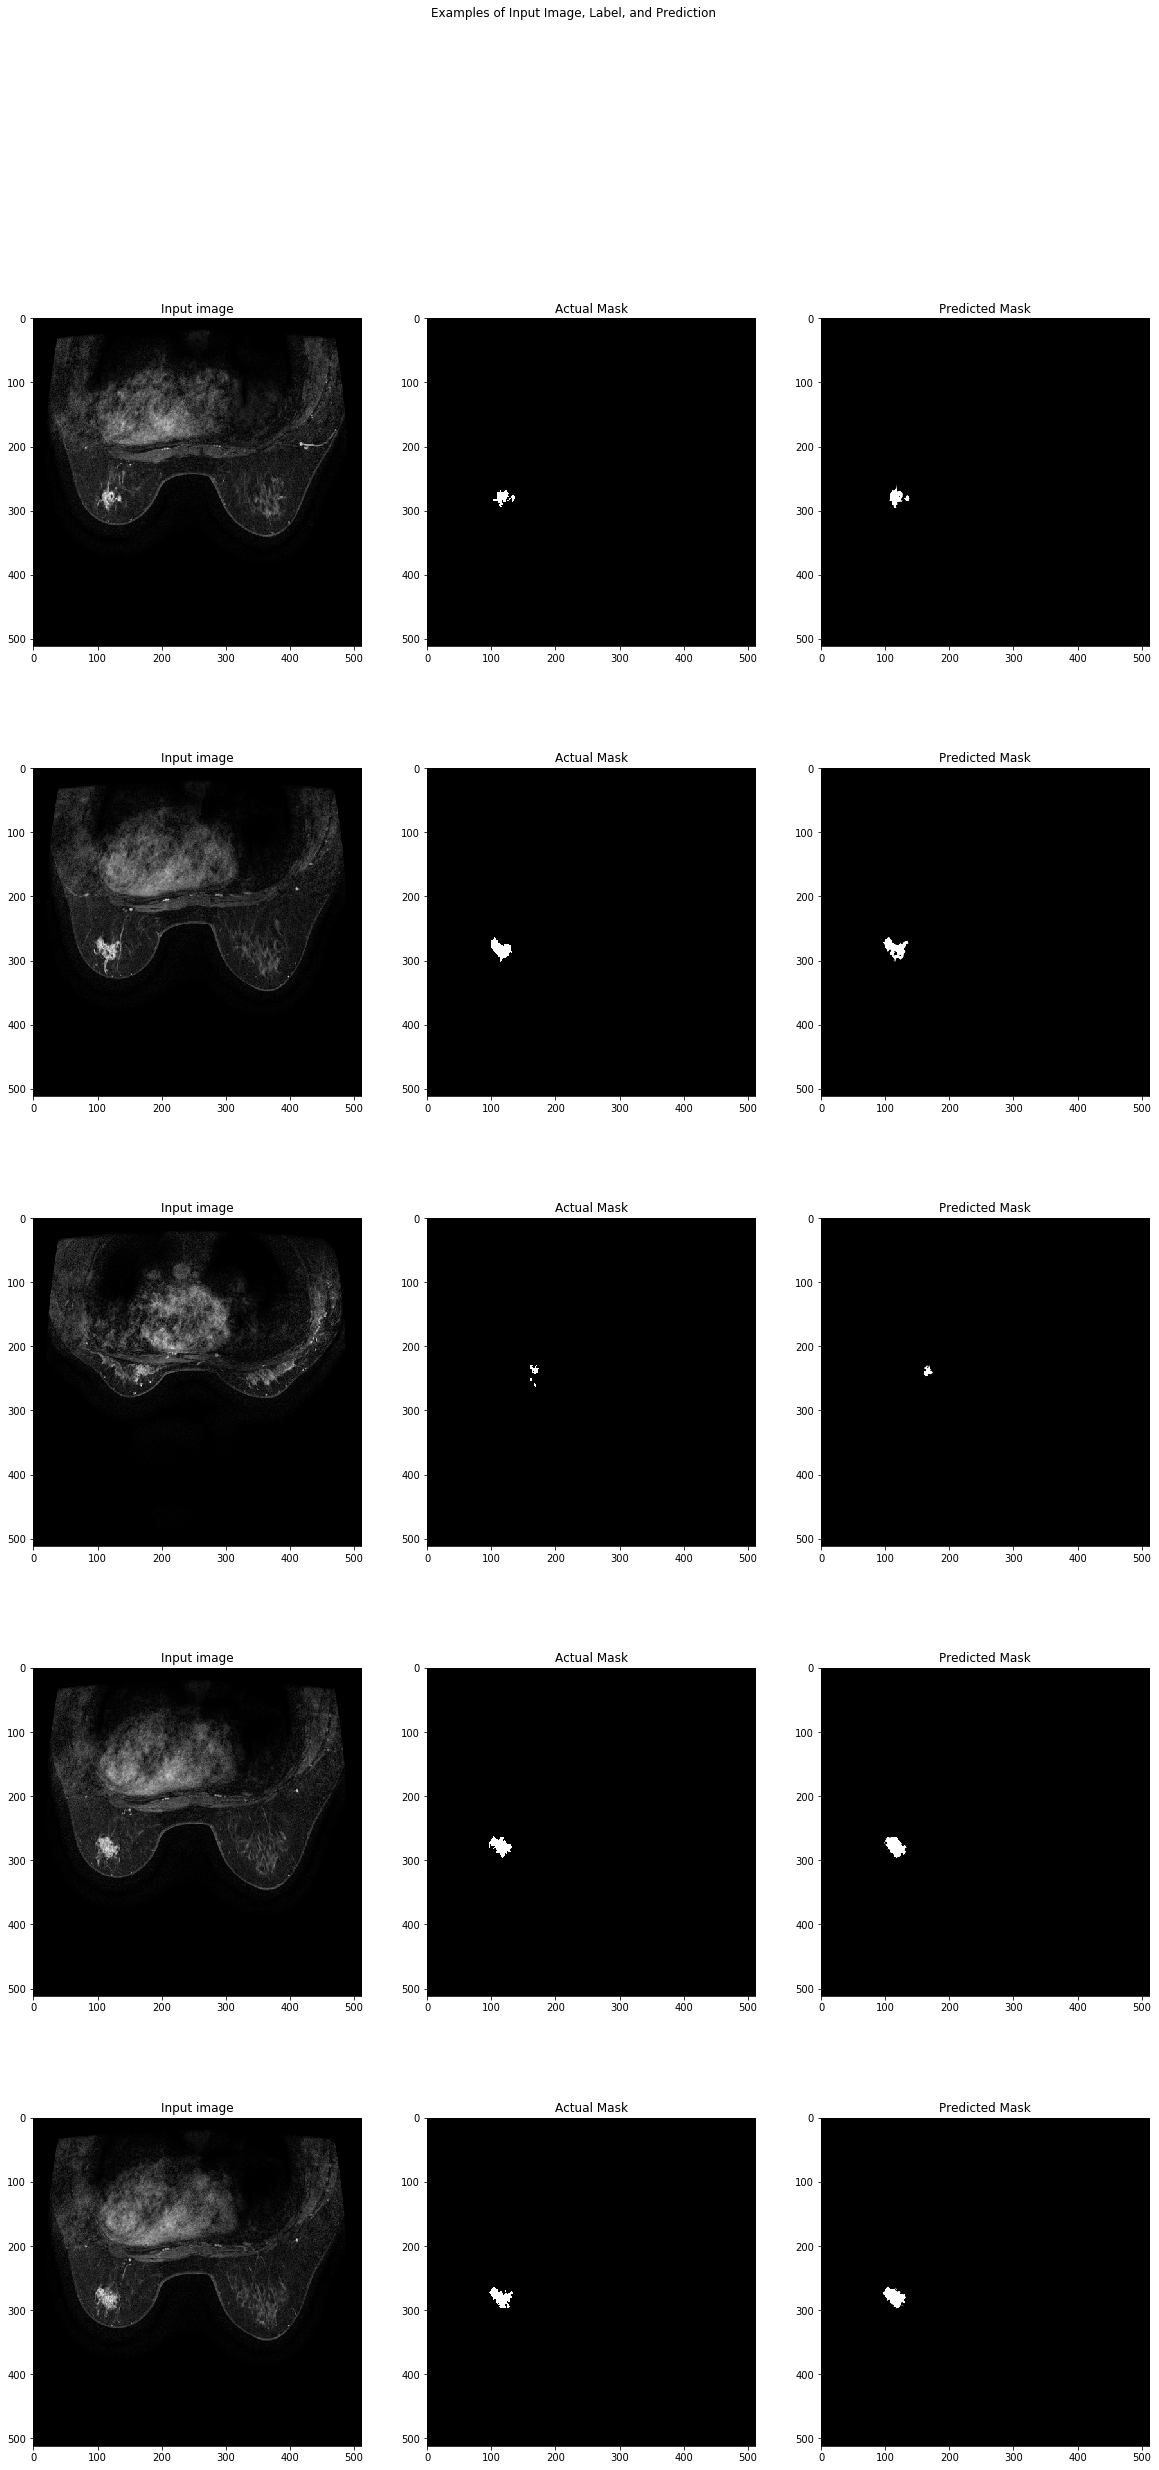

In [118]:
# Let's visualize some of the outputs
data_aug_iter = val_ds.make_one_shot_iterator()
next_element = data_aug_iter.get_next()

# Running next element in our graph will produce a batch of images
fig = plt.figure(figsize=(20, 40))
for i in range(5):
    batch_of_imgs, label = tf.keras.backend.get_session().run(next_element)
    img = batch_of_imgs[0]
    predicted_label = model.predict(batch_of_imgs)[0]

    plt.subplot(5, 3, 3 * i + 1)
    plt.imshow(img)
    plt.title("Input image")

    plt.subplot(5, 3, 3 * i + 2)
    plt.imshow(label[0, :, :, 0], cmap="gray")
    plt.title("Actual Mask")
    plt.subplot(5, 3, 3 * i + 3)
    plt.imshow(predicted_label[:, :, 0], cmap="gray")
    plt.title("Predicted Mask")
plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.show()